In [1]:
from starccato_flow.data.ccsn_data import CCSNData
from starccato_flow.data.toy_data import ToyData
from starccato_flow.training.trainer_vae import VAETrainer
from starccato_flow.training.trainer_cvae import ConditionalVAETrainer

/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MPS device found


/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


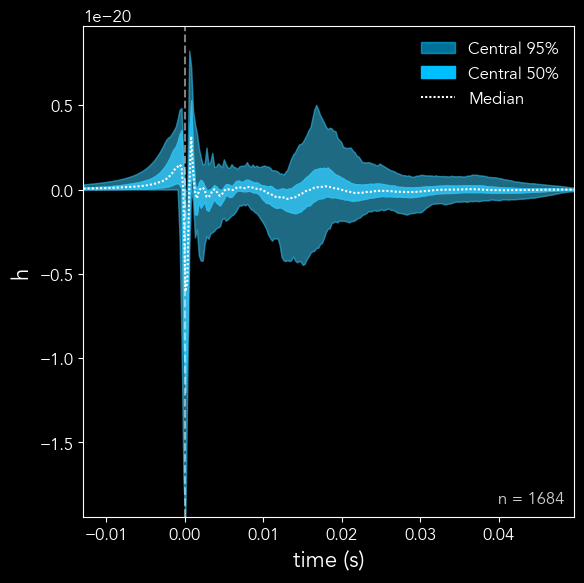

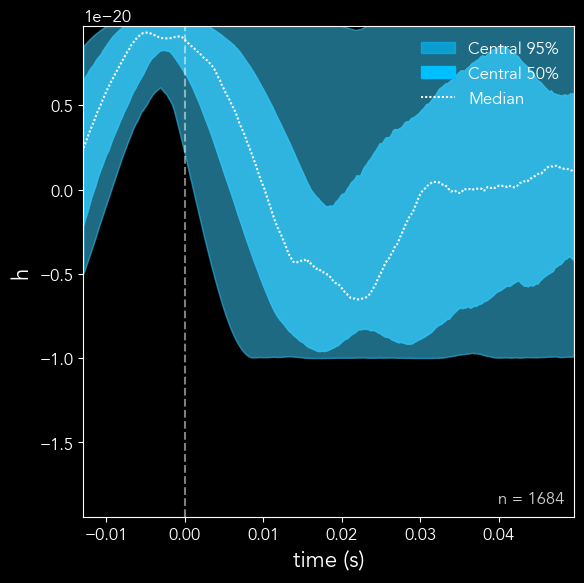

In [2]:
ccsn_dataset = CCSNData(noise=True, curriculum=False)
ccsn_dataset.plot_signal_distribution(background="black", font_family="sans-serif", font_name="Avenir", fname="plots/ccsn_signal_distribution.svg")

toy_dataset = ToyData(noise=False, curriculum=False)
toy_dataset.plot_signal_distribution(background="black", font_family="sans-serif", font_name="Avenir", fname="plots/toy_signal_distribution.svg")

In [3]:
trainer = ConditionalVAETrainer(
    toy=True, 
    num_epochs=256,
    noise=False, 
    curriculum=False,
    validation_split=0.1,
    noise_realizations=1
)


=== Toy Data Split ===
Total signals: 1684
Training signals: 1516
Validation signals: 168

Verifying data alignment:
Number of signals: 1516
Number of parameter sets: 1516

Verifying data alignment:
Number of signals: 168
Number of parameter sets: 168

Parameter dimension: 2
Parameter names: ['x', 'y']

=== Dataset Sizes ===
Training samples: 1516
Validation samples: 168



DIAGNOSTIC: Dataset Information
Max strain in dataset: 1.000000e-20
Sample raw signal range: [-9.999281e-21, 9.999369e-21]

Parameter ranges in dataset:
  Param 0: [-1.1124, 2.1441]
  Param 1: [-0.6194, 1.1347]

Testing parameter normalization:
  Raw param (min, min): [-1.1123825  -0.61942977]
  Normalized: [-1. -1.]
  Raw param (max, max): [2.1440618 1.134667 ]
  Normalized: [1. 1.]

Starting training...



Epochs:   6%|▌         | 15/256 [00:16<03:55,  1.02it/s]


Epoch 16/256
  Train Loss: 41.9564 | Val Loss: 36.7933
  Generated signals shape: (16, 256)
  Parameter Sensitivity Check:
    Mean absolute difference: 0.931056
    Relative difference: 1.4149
    ✓ Model is using parameters (signals differ)


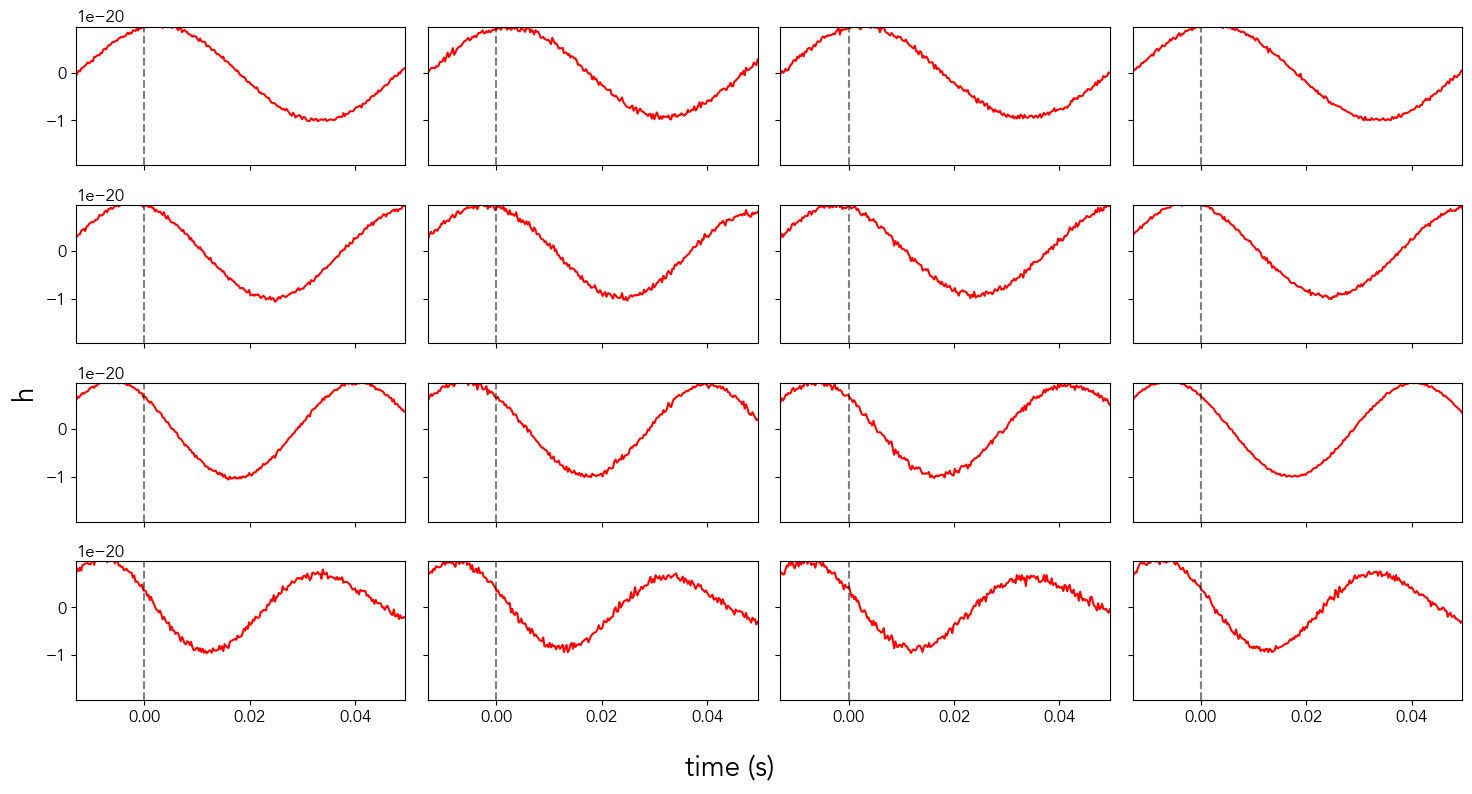

Epochs:   6%|▋         | 16/256 [00:19<06:41,  1.67s/it]

  Saved latent space plot to plots/cvae_latent_space_epoch_16.svg


Epochs:  12%|█▏        | 31/256 [00:33<03:28,  1.08it/s]


Epoch 32/256
  Train Loss: 27.0599 | Val Loss: 19.1480
  Generated signals shape: (16, 256)
  Parameter Sensitivity Check:
    Mean absolute difference: 0.941139
    Relative difference: 1.4266
    ✓ Model is using parameters (signals differ)


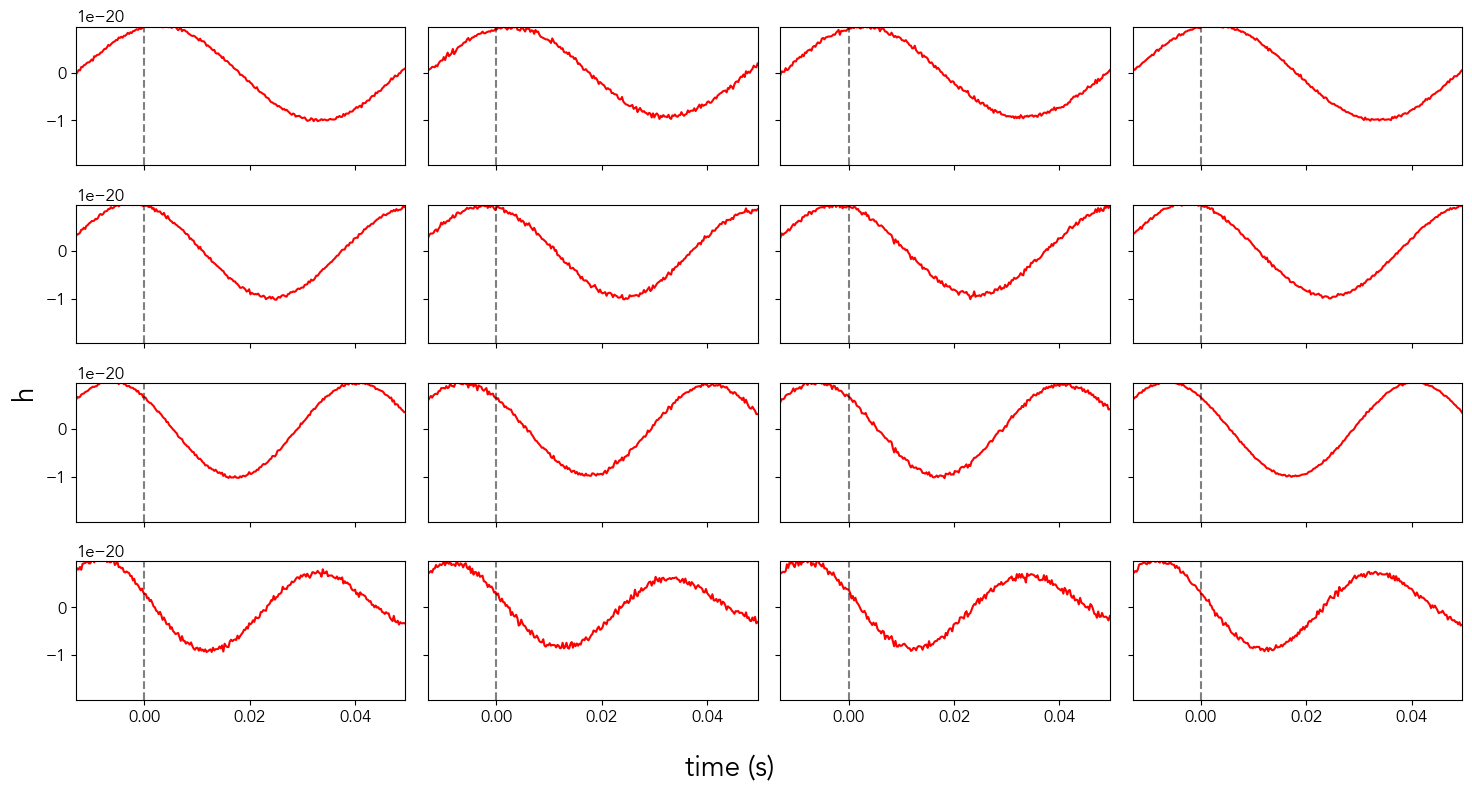

Epochs:  12%|█▎        | 32/256 [00:36<05:55,  1.59s/it]

  Saved latent space plot to plots/cvae_latent_space_epoch_32.svg


Epochs:  18%|█▊        | 47/256 [00:50<03:20,  1.04it/s]


Epoch 48/256
  Train Loss: 19.5637 | Val Loss: 20.4404
  Generated signals shape: (16, 256)
  Parameter Sensitivity Check:
    Mean absolute difference: 0.933629
    Relative difference: 1.4338
    ✓ Model is using parameters (signals differ)


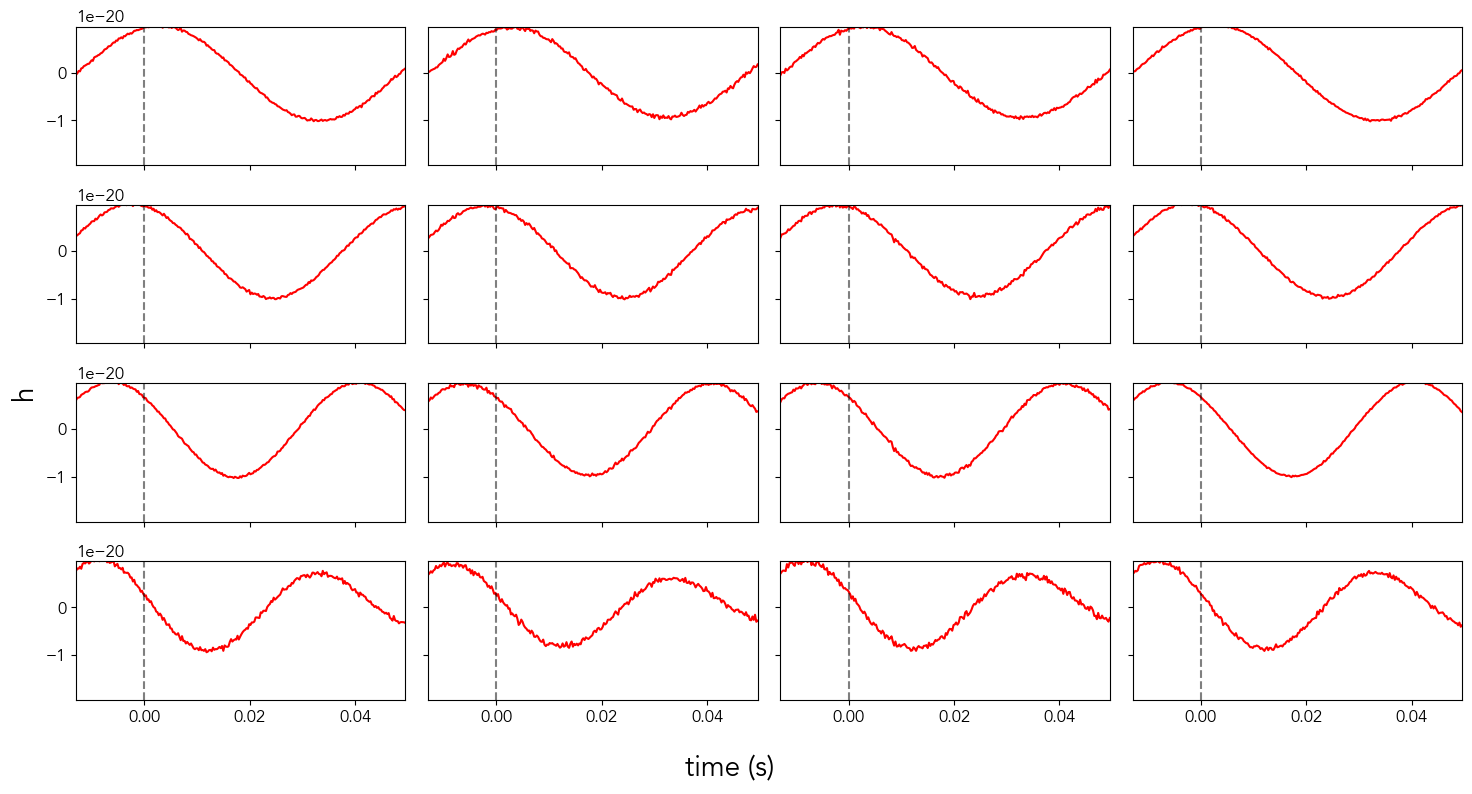

Epochs:  19%|█▉        | 48/256 [00:54<06:10,  1.78s/it]

  Saved latent space plot to plots/cvae_latent_space_epoch_48.svg


Epochs:  25%|██▍       | 63/256 [01:08<03:00,  1.07it/s]


Epoch 64/256
  Train Loss: 17.1427 | Val Loss: 20.4193
  Generated signals shape: (16, 256)
  Parameter Sensitivity Check:
    Mean absolute difference: 0.914709
    Relative difference: 1.4273
    ✓ Model is using parameters (signals differ)


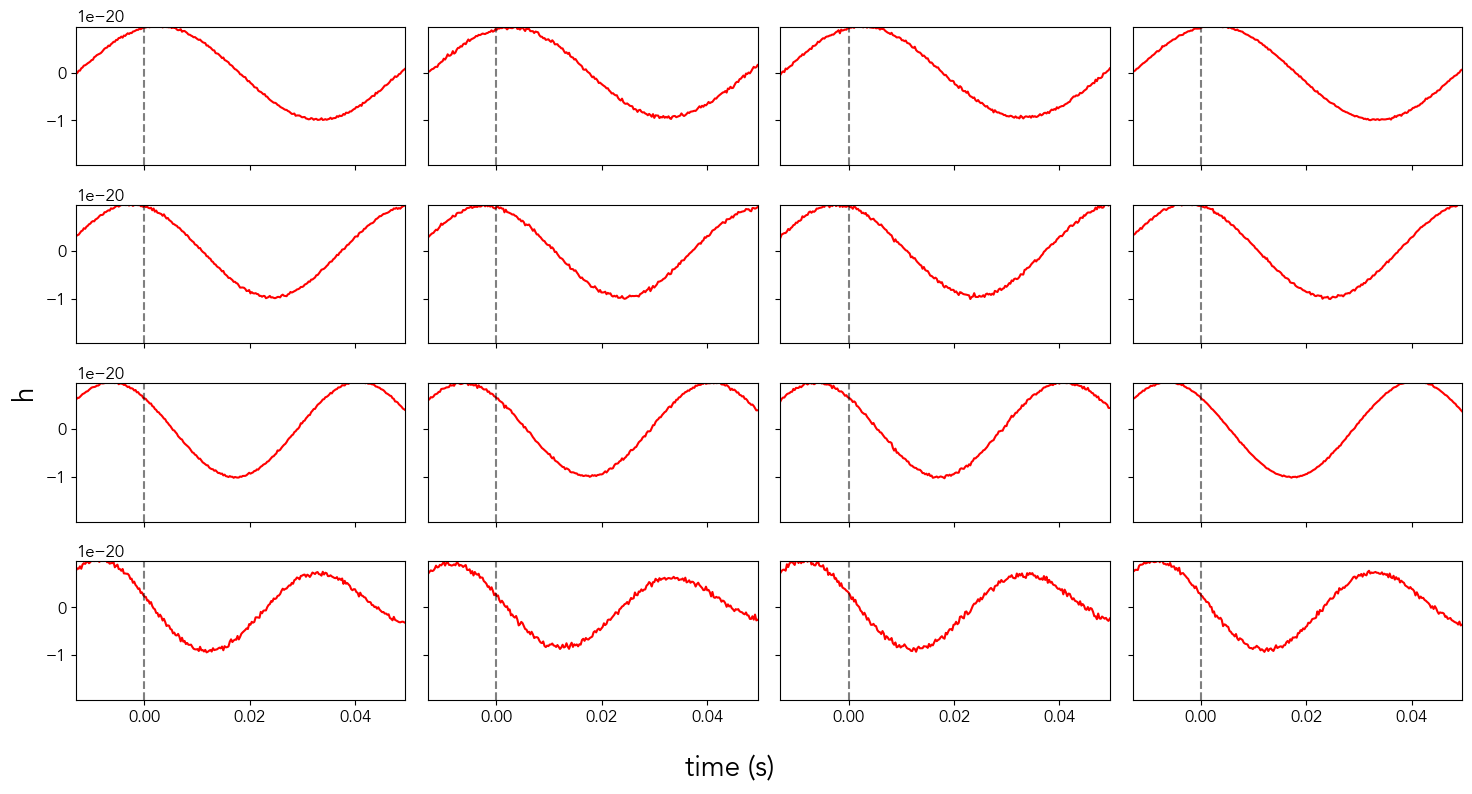

Epochs:  25%|██▌       | 64/256 [01:11<04:54,  1.53s/it]

  Saved latent space plot to plots/cvae_latent_space_epoch_64.svg


Epochs:  31%|███       | 79/256 [01:26<03:00,  1.02s/it]


Epoch 80/256
  Train Loss: 15.3372 | Val Loss: 12.2910
  Generated signals shape: (16, 256)
  Parameter Sensitivity Check:
    Mean absolute difference: 0.934055
    Relative difference: 1.4243
    ✓ Model is using parameters (signals differ)


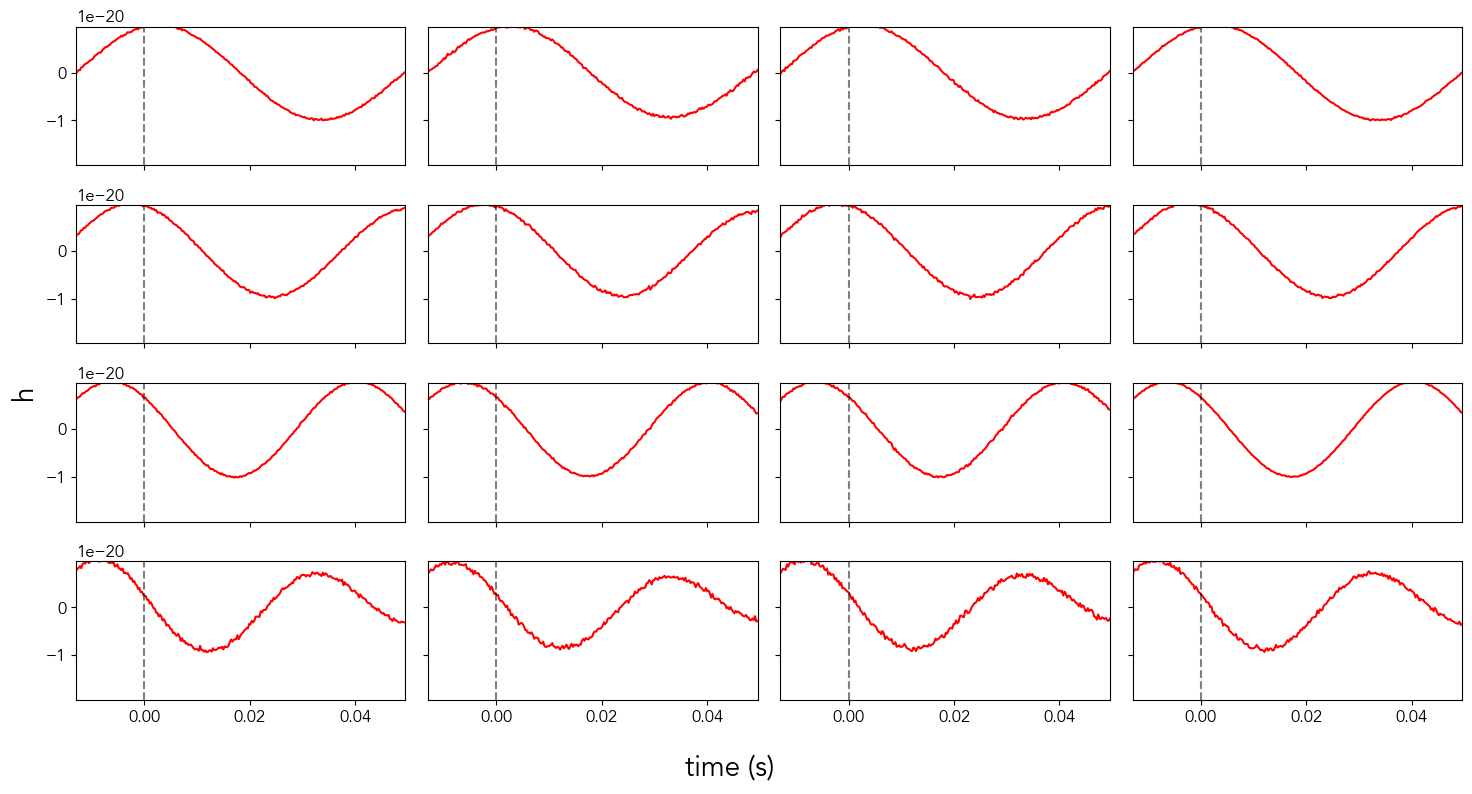

Epochs:  31%|███▏      | 80/256 [01:29<04:59,  1.70s/it]

  Saved latent space plot to plots/cvae_latent_space_epoch_80.svg


Epochs:  37%|███▋      | 95/256 [01:44<02:48,  1.04s/it]


Epoch 96/256
  Train Loss: 16.5321 | Val Loss: 14.4868
  Generated signals shape: (16, 256)
  Parameter Sensitivity Check:
    Mean absolute difference: 0.927500
    Relative difference: 1.4242
    ✓ Model is using parameters (signals differ)


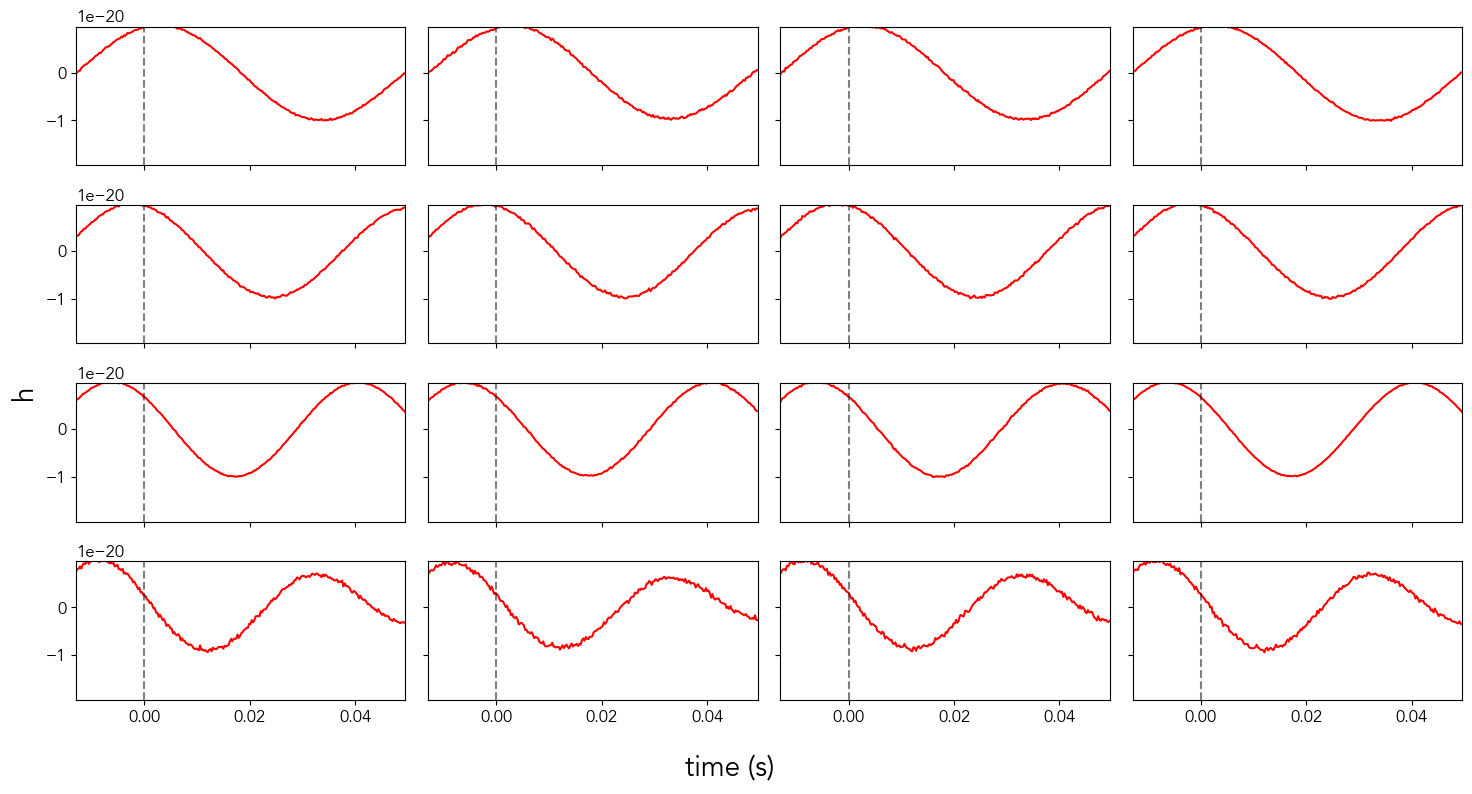

Epochs:  38%|███▊      | 96/256 [01:47<04:32,  1.70s/it]

  Saved latent space plot to plots/cvae_latent_space_epoch_96.svg


Epochs:  43%|████▎     | 111/256 [02:01<02:21,  1.02it/s]


Epoch 112/256
  Train Loss: 12.5776 | Val Loss: 7.7413
  Generated signals shape: (16, 256)
  Parameter Sensitivity Check:
    Mean absolute difference: 0.926386
    Relative difference: 1.4255
    ✓ Model is using parameters (signals differ)


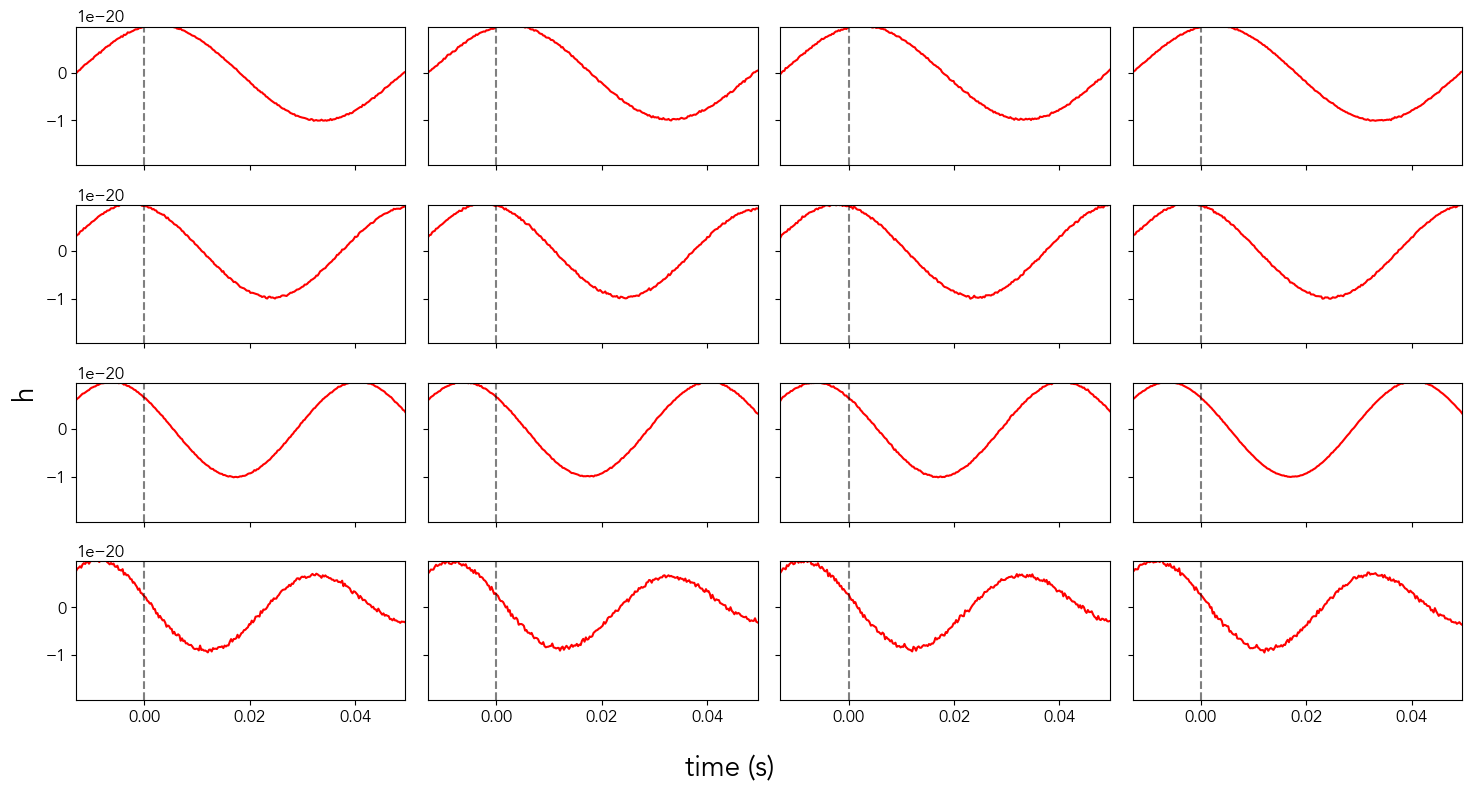

Epochs:  44%|████▍     | 112/256 [02:04<03:54,  1.63s/it]

  Saved latent space plot to plots/cvae_latent_space_epoch_112.svg


Epochs:  50%|████▉     | 127/256 [02:19<02:01,  1.06it/s]


Epoch 128/256
  Train Loss: 11.8980 | Val Loss: 26.6592
  Generated signals shape: (16, 256)
  Parameter Sensitivity Check:
    Mean absolute difference: 0.931964
    Relative difference: 1.4309
    ✓ Model is using parameters (signals differ)


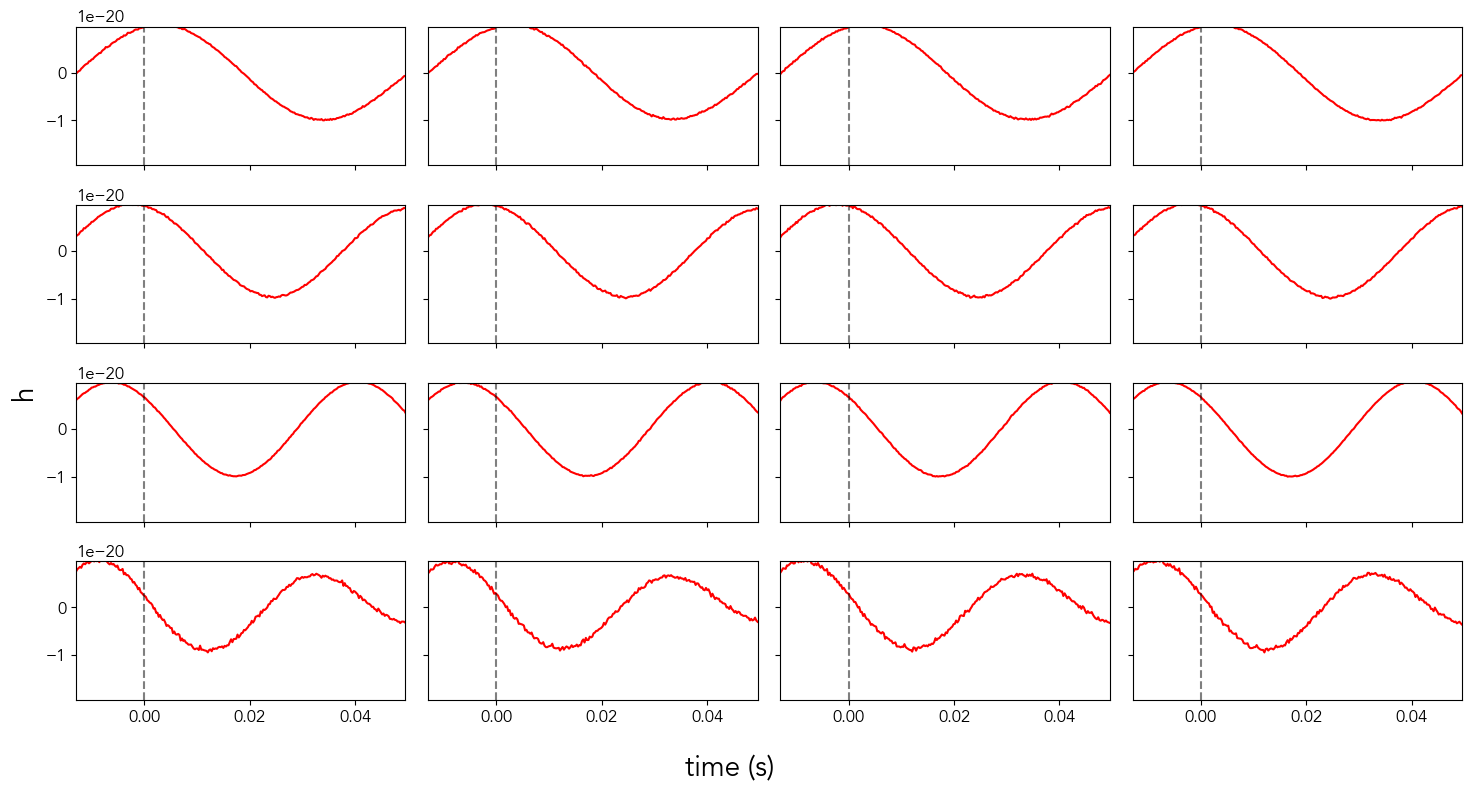

Epochs:  50%|█████     | 128/256 [02:22<03:17,  1.55s/it]

  Saved latent space plot to plots/cvae_latent_space_epoch_128.svg


Epochs:  56%|█████▌    | 143/256 [02:37<01:50,  1.03it/s]

In [ ]:
trainer.train()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from starccato_flow.utils.defaults import DEVICE

# Test: Generate signals with DIFFERENT parameter values
print("Testing CVAE parameter conditioning...")
print("=" * 60)

# Define 3 different parameter sets
if trainer.param_dim == 1:
    param_sets = [
        np.array([0.02]),   # Low beta
        np.array([0.10]),   # Medium beta
        np.array([0.18])    # High beta
    ]
    param_labels = ['β=0.02', 'β=0.10', 'β=0.18']
elif trainer.param_dim == 4:
    param_sets = [
        np.array([0.02, 6.0, 3000.0, 0.10]),   # Low values
        np.array([0.10, 10.0, 6000.0, 0.15]),  # Medium values
        np.array([0.18, 14.0, 9000.0, 0.20])   # High values
    ]
    param_labels = ['Low', 'Medium', 'High']
else:
    param_sets = [np.zeros(trainer.param_dim) for _ in range(3)]
    param_labels = ['Set 1', 'Set 2', 'Set 3']

# Normalize parameters
param_sets_norm = [trainer.training_dataset.normalize_parameters(p) for p in param_sets]

# Generate noise samples ONCE (will be reused for all parameter sets)
num_samples_per_set = 3
z_samples = torch.randn(num_samples_per_set, trainer.z_dim).to(DEVICE)
print(f"\nUsing {num_samples_per_set} shared noise samples across all parameter sets")

trainer.cvae.eval()

fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# First pass: generate all signals and find global y-limits
all_signals_scaled = []
with torch.no_grad():
    for i, (params_norm, params_raw, label) in enumerate(zip(param_sets_norm, param_sets, param_labels)):
        # Use the SAME z_samples for all parameter sets
        params_tensor = torch.tensor(params_norm, dtype=torch.float32).unsqueeze(0).repeat(num_samples_per_set, 1).to(DEVICE)
        
        generated = trainer.cvae.decoder(z_samples, params_tensor).cpu().numpy()
        
        for j in range(num_samples_per_set):
            signal_denorm = trainer.training_dataset.denormalise_signals(generated[j])
            signal_scaled = signal_denorm / 1e-20
            all_signals_scaled.append(signal_scaled)

# Calculate global y-limits
all_signals_array = np.array(all_signals_scaled)
y_min = all_signals_array.min()
y_max = all_signals_array.max()
y_margin = (y_max - y_min) * 0.1

# Second pass: plot with consistent y-limits
idx = 0
with torch.no_grad():
    for i, (params_norm, params_raw, label) in enumerate(zip(param_sets_norm, param_sets, param_labels)):
        for j in range(num_samples_per_set):
            signal_scaled = all_signals_scaled[idx]
            time = np.arange(len(signal_scaled)) / 16384
            
            axes[i, j].plot(time, signal_scaled, linewidth=0.8, color='#2c3e50')
            axes[i, j].set_ylabel('Strain (×10⁻²⁰)', fontsize=9)
            axes[i, j].set_ylim(y_min - y_margin, y_max + y_margin)
            axes[i, j].grid(True, alpha=0.3)
            axes[i, j].axhline(y=0, color='gray', linestyle='--', alpha=0.3)
            
            if i == 0:
                axes[i, j].set_title(f'Noise Sample {j+1}', fontsize=10)
            if i == 2:
                axes[i, j].set_xlabel('Time (s)', fontsize=9)
            if j == 0:
                if trainer.param_dim == 1:
                    axes[i, j].text(-0.3, 0.5, label, transform=axes[i, j].transAxes, 
                                   fontsize=11, va='center', rotation=90, weight='bold')
                else:
                    param_str = f"β={params_raw[0]:.2f}\nω={params_raw[1]:.1f}"
                    axes[i, j].text(-0.35, 0.5, param_str, transform=axes[i, j].transAxes, 
                                   fontsize=9, va='center', rotation=90)
            
            idx += 1

plt.suptitle('CVAE Generation Test: Same Noise, Different Parameters', fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig('plots/cvae_parameter_test.svg', bbox_inches='tight', dpi=150)
plt.show()

print("\n✓ If the model is learning parameters correctly:")
print("  - Each COLUMN should show consistent structure (same noise)")
print("  - Different ROWS should look different (different parameters)")
print("  - Signals in same column vary due to parameter changes, not noise")
print("\nIf all signals look too similar → model NOT learning parameters")
print("If columns show inconsistent structure → check noise reuse logic")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ========== CHOOSE YOUR TARGET PARAMETER VALUES HERE ==========
target_beta = 0.05    # Beta value
target_omega = None    # Set to a value like 10.0 for omega, or None to ignore
# ================================================================

# Get parameters from training dataset
params = trainer.training_dataset.parameters
num_params = params.shape[1]
param_names = trainer.training_dataset.parameter_names

print(f"Dataset has {num_params} parameter(s): {param_names}")

# Build target vector based on available parameters
if num_params == 1:
    # Only beta available
    target_vector = np.array([target_beta])
    print(f"\nSearching for signals near: β = {target_beta:.6f}")
elif num_params == 4:
    # Beta, omega, A, Ye available
    if target_omega is None:
        print("\nNote: You have 4 parameters but target_omega is None. Finding signals with similar beta only.")
        # Find signals with closest beta
        beta_values = params[:, 0]
        differences = np.abs(beta_values - target_beta)
        closest_indices = np.argsort(differences)[:2]
    else:
        # Match on both beta and omega
        target_vector = np.array([target_beta, target_omega, 0.0, 0.0])  # A and Ye set to 0 for now
        print(f"\nSearching for signals near: β = {target_beta:.6f}, ω₀ = {target_omega:.6f}")
        # Calculate Euclidean distance for beta and omega only
        differences = np.sqrt((params[:, 0] - target_beta)**2 + (params[:, 1] - target_omega)**2)
        closest_indices = np.argsort(differences)[:2]
else:
    # Use all available parameters
    target_vector = np.array([target_beta] + [0.0] * (num_params - 1))
    print(f"\nSearching for signals near target values")

# For single parameter case
if num_params == 1:
    differences = np.abs(params[:, 0] - target_beta)
    closest_indices = np.argsort(differences)[:2]

idx1, idx2 = closest_indices[0], closest_indices[1]

# Get the signals
signal1, _, param1 = trainer.training_dataset[idx1]
signal2, _, param2 = trainer.training_dataset[idx2]

# Denormalize for plotting
signal1_denorm = trainer.training_dataset.denormalise_signals(signal1.cpu().numpy().flatten())
signal2_denorm = trainer.training_dataset.denormalise_signals(signal2.cpu().numpy().flatten())
param1_denorm = trainer.training_dataset.denormalize_parameters(param1.cpu().numpy().flatten())
param2_denorm = trainer.training_dataset.denormalize_parameters(param2.cpu().numpy().flatten())

print(f"\nSignal 1 - Index: {idx1}")
print(f"  β = {param1_denorm[0]:.6f} (Δ = {abs(param1_denorm[0] - target_beta):.6f})")
if num_params == 4 and target_omega is not None:
    print(f"  ω₀ = {param1_denorm[1]:.6f} (Δ = {abs(param1_denorm[1] - target_omega):.6f})")

print(f"\nSignal 2 - Index: {idx2}")
print(f"  β = {param2_denorm[0]:.6f} (Δ = {abs(param2_denorm[0] - target_beta):.6f})")
if num_params == 4 and target_omega is not None:
    print(f"  ω₀ = {param2_denorm[1]:.6f} (Δ = {abs(param2_denorm[1] - target_omega):.6f})")

# Calculate global y-limits for consistent scaling
signal1_scaled = signal1_denorm / 1e-20
signal2_scaled = signal2_denorm / 1e-20
y_min = min(signal1_scaled.min(), signal2_scaled.min())
y_max = max(signal1_scaled.max(), signal2_scaled.max())
y_margin = (y_max - y_min) * 0.1  # Add 10% margin

# Plot the two signals
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
time = np.arange(len(signal1_denorm)) / 16384  # Assuming 16384 Hz sampling rate

# Build title strings
if num_params == 4 and target_omega is not None:
    title1 = f'Signal {idx1}: β = {param1_denorm[0]:.6f}, ω₀ = {param1_denorm[1]:.6f}'
    title2 = f'Signal {idx2}: β = {param2_denorm[0]:.6f}, ω₀ = {param2_denorm[1]:.6f}'
    suptitle = f'Two Signals Closest to Target β = {target_beta:.6f}, ω₀ = {target_omega:.6f}'
else:
    title1 = f'Signal {idx1}: β = {param1_denorm[0]:.6f}'
    title2 = f'Signal {idx2}: β = {param2_denorm[0]:.6f}'
    suptitle = f'Two Signals Closest to Target β = {target_beta:.6f}'

axes[0].plot(time, signal1_scaled, linewidth=1, color='#3498db')
axes[0].set_ylabel('Strain (×10⁻²⁰)', fontsize=12)
axes[0].set_title(title1, fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.3)
axes[0].set_ylim(y_min - y_margin, y_max + y_margin)

axes[1].plot(time, signal2_scaled, linewidth=1, color='#e74c3c')
axes[1].set_xlabel('Time (s)', fontsize=12)
axes[1].set_ylabel('Strain (×10⁻²⁰)', fontsize=12)
axes[1].set_title(title2, fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.3)
axes[1].set_ylim(y_min - y_margin, y_max + y_margin)

plt.suptitle(suptitle, fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from starccato_flow.utils.defaults import DEVICE

# Encode the two signals to latent space
with torch.no_grad():
    # Get normalized signals (already in normalized form from __getitem__)
    signal1_norm = torch.tensor(trainer.training_dataset.normalise_signals(signal1_denorm), dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device=DEVICE)
    signal2_norm = torch.tensor(trainer.training_dataset.normalise_signals(signal2_denorm), dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device=DEVICE)

    # Encode to latent space
    mu1, logvar1 = trainer.vae.encoder(signal1_norm)
    mu2, logvar2 = trainer.vae.encoder(signal2_norm)
    
    # Use mean (mu) for interpolation (not sampling)
    z1 = mu1
    z2 = mu2
    
    print(f"Latent vector 1 shape: {z1.shape}")
    print(f"Latent vector 2 shape: {z2.shape}")
    
    # Interpolate in latent space (midpoint)
    z_interpolated = (z1 + z2) / 2.0
    
    print(f"Interpolated latent vector shape: {z_interpolated.shape}")
    print(f"Distance between z1 and z2: {torch.norm(z2 - z1).item():.6f}")
    
    # Decode interpolated latent vector
    interpolated_signal_norm = trainer.vae.decoder(z_interpolated).cpu().numpy().flatten()
    
# Denormalize the interpolated signal
interpolated_signal = trainer.training_dataset.denormalise_signals(interpolated_signal_norm)

# Plot all three signals
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
time = np.arange(len(signal1_denorm)) / 16384

# Scale all signals
signal1_scaled = signal1_denorm / 1e-20
signal2_scaled = signal2_denorm / 1e-20
interpolated_scaled = interpolated_signal / 1e-20

# Calculate global y-limits for consistent scaling
y_min = min(signal1_scaled.min(), signal2_scaled.min(), interpolated_scaled.min())
y_max = max(signal1_scaled.max(), signal2_scaled.max(), interpolated_scaled.max())
y_margin = (y_max - y_min) * 0.1

# Plot signal 1
axes[0].plot(time, signal1_scaled, linewidth=1, color='#3498db')
axes[0].set_ylabel('Strain (×10⁻²⁰)', fontsize=12)
axes[0].set_title(f'Original Signal {idx1}: β = {param1_denorm[0]:.6f}', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.3)
axes[0].set_ylim(y_min - y_margin, y_max + y_margin)

# Plot interpolated signal
axes[1].plot(time, interpolated_scaled, linewidth=1, color='#2ecc71')
axes[1].set_ylabel('Strain (×10⁻²⁰)', fontsize=12)
axes[1].set_title(f'Interpolated Signal (Latent Space Midpoint)', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.3)
axes[1].set_ylim(y_min - y_margin, y_max + y_margin)

# Plot signal 2
axes[2].plot(time, signal2_scaled, linewidth=1, color='#e74c3c')
axes[2].set_xlabel('Time (s)', fontsize=12)
axes[2].set_ylabel('Strain (×10⁻²⁰)', fontsize=12)
axes[2].set_title(f'Original Signal {idx2}: β = {param2_denorm[0]:.6f}', fontsize=14)
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='gray', linestyle='--', alpha=0.3)
axes[2].set_ylim(y_min - y_margin, y_max + y_margin)

plt.suptitle('Latent Space Interpolation Between Two Signals', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

print(f"\nInterpolated signal statistics:")
print(f"  Min: {interpolated_signal.min():.2e}")
print(f"  Max: {interpolated_signal.max():.2e}")
print(f"  Mean: {interpolated_signal.mean():.2e}")

# Conditional VAE Architecture Concept

A **Conditional VAE (CVAE)** would solve the "unknown parameters" problem by explicitly conditioning generation on physical parameters.

## Key Differences from Regular VAE:

### Regular VAE (current):
- **Encoder**: `signal → z` (learns implicit parameter representation)
- **Decoder**: `z → signal` (no control over parameters)
- **Problem**: Interpolated signals have unknown physical parameters

### Conditional VAE:
- **Encoder**: `(signal, parameters) → z` (learns residual/noise)
- **Decoder**: `(z, parameters) → signal` (explicit parameter control)
- **Advantage**: Can generate signals with **any** specified parameter values!

## Architecture Modifications Needed:

```python
class ConditionalEncoder(nn.Module):
    def __init__(self, signal_length, param_dim, z_dim):
        # 1. Signal processing branch (CNN)
        # 2. Parameter embedding (MLP)
        # 3. Combine features → z (mean, logvar)
        
class ConditionalDecoder(nn.Module):
    def __init__(self, z_dim, param_dim, signal_length):
        # 1. Combine z + parameters
        # 2. Generate signal conditioned on parameters
```

## Benefits for Your Use Case:

1. **Controlled Data Augmentation**: Generate signals for specific β, ω₀, A, Yₑ values
2. **Known Ground Truth**: Every generated signal has known parameters
3. **Dense Sampling**: Fill gaps in sparse parameter space (1684 → 10000+ samples)
4. **Physics-Aware**: Model learns parameter → signal mapping explicitly

## Training Strategy:

```python
# Standard CVAE training
for signal, params in dataloader:
    # Encode with conditioning
    z_mean, z_logvar = encoder(signal, params)
    z = reparameterize(z_mean, z_logvar)
    
    # Decode with conditioning
    reconstructed = decoder(z, params)
    
    # Loss = reconstruction + KL divergence (same as VAE)
    loss = mse_loss(signal, reconstructed) + kl_divergence(z_mean, z_logvar)
```

## Data Augmentation with CVAE:

```python
# Generate new signals with specific parameters
target_params = np.array([0.055, 8.5, 5000, 0.12])  # β, ω₀, A, Yₑ
z_random = torch.randn(100, z_dim)  # 100 random latent vectors

# Expand params to batch
params_batch = torch.tensor(target_params).repeat(100, 1)

# Generate 100 signals with same parameters (different noise realizations)
generated_signals = decoder(z_random, params_batch)
```

This would be **much better** for training your flow matching model since every generated signal would have known ground truth parameters!